In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from MDAnalysis.analysis import leaflet
from skspatial.objects import Line
from skspatial.objects import Points
import math as m

from utils.classes import Peptide

In [28]:
step_size = 500 
membrane_lipids = 512
peptide_name = "WF2_8_1"

peptide = Peptide(
    pep_name=peptide_name,
    xtc_file_path="/Volumes/miru_back/young_concentration_WF2/WF2_8/md_0_1_combined_first500ns_pbc.xtc",
    tpr_file_path="/Volumes/miru_back/young_concentration_WF2/WF2_8/md_0_1.tpr",
    peptide_number=8, amino_acid_count=25, step_size=step_size)

In [32]:
def find_consecutive_sublists(integers):
    if not integers:
        return []

    # Sort the list
    integers.sort()

    # Initialize variables
    result = []
    current_sublist = [integers[0]]

    # Iterate through the sorted list
    for i in range(1, len(integers)):
        # Check if the current integer is consecutive to the previous one
        if integers[i] == integers[i - 1] + 1:
            current_sublist.append(integers[i])
        else:
            # If the current sublist has at least 5 consecutive integers, add it to the result
            if len(current_sublist) >= 5:
                result.append(current_sublist)
            # Start a new sublist
            current_sublist = [integers[i]]

    # Check the last sublist
    if len(current_sublist) >= 5:
        result.append(current_sublist)

    return result

def get_vector(coord1, coord2):
    return (coord1[0]-coord2[0], coord1[0]-coord2[1], coord1[0]-coord2[2])

def vector_length(v):
    return m.sqrt(sum((c ** 2) for c in v))

def dot(v1, v2):
    return sum([c1 * c2 for c1, c2 in zip(v1, v2)])

def angle_between_vectors(v1, v2):
    return m.acos(dot(v1, v2) / (vector_length(v1) * vector_length(v2))) * (180 / m.pi)


def helix_tilt(obj, peptide_name):
    u = obj.u
    pep_num_dict =obj.pep_dict
    box = u.dimensions
    x_memb, y_memb = box[0], box[1]
    angle_list = []
    for ts in tqdm(u.trajectory[::100]):
        L = leaflet.LeafletFinder(u, 'name P')

        z_memb = np.mean(L.groups(0).positions[:,[2]])
        memb_vector = (x_memb, y_memb, z_memb)
        

        for pep, residues in pep_num_dict.items():
            timecount1 = u.trajectory.time

            c1 = u.select_atoms(f"name CA and resid {residues[0]+1}").positions
            c2 = u.select_atoms(f"name CA and resid {residues[-1]+1}").positions
           
            pep_vector = get_vector([c1[:,[i]] for i in range (3)], [c2[:,[i]] for i in range (3)])


            tilt_angle = angle_between_vectors(pep_vector, memb_vector)
            angle_list.append((timecount1, pep , abs(90-tilt_angle)))
    df = pd.DataFrame(angle_list, columns=["Time (ns)", "Peptide_num", "Angle"])
    df['Angle']= df['Angle'].astype(float)
    df['Time (ns)'] = df['Time (ns)'].astype(float)/1000
    df['Time (ns)'] = df['Time (ns)'].astype(int)

    df.to_csv(f"tilt_angles/tilt_angle_{peptide_name}.csv")
    return df

def get_coords_spanning_memb(u, residues, p_up):
    pep_coords = []
    selected_res = []
    for res_id in range(residues[0], residues[1]+1):
        peptide_atoms = u.select_atoms(f"name CA and resid {res_id}").positions
    
        z_pep = peptide_atoms[:,[2]].astype(float)
        # inside the radius
        if z_pep < p_up+10 and z_pep > p_up-6:
            selected_res.append(res_id+1)
    final_residues = find_consecutive_sublists(selected_res)
    pep_coords = [[u.select_atoms(f"name CA and resid {res_id}").positions.reshape(-1).astype(float).tolist() for res_id in sub_list if len(u.select_atoms(f"name CA and resid {res_id}").positions.reshape(-1).astype(float).tolist())>0] for sub_list in final_residues]
    return pep_coords, selected_res

def relative_tilt(obj, membrane_lipids):
    """
    Compute relative tilt angle only for the upper bilayer
    """
    u = obj.u
    peptide_name = obj.pep_name
    pep_num_dict = obj.pep_dict
    frames, n_frames = obj.load_traj()
    box = u.dimensions
    x_memb, y_memb = box[0], box[1]
    angle_list = []
    for _, ts in tqdm(enumerate(u.trajectory[frames]), total=n_frames):
        timecount1 = u.trajectory.time
        if timecount1!=0:
            L = leaflet.LeafletFinder(u, 'name P')
            memb_vector = (0, 0, 1)
            
            p_memb = u.select_atoms(f'resname POPG and name P').positions[:,[2]].astype(float)
            p_up = np.mean(p_memb[:membrane_lipids/2])

            for pep, residues in pep_num_dict.items():
                
                pep_coords, _ = get_coords_spanning_memb(u,residues, p_up)
                if len(pep_coords)==0 or len(pep_coords)>1:
                    angle_list.append((timecount1, pep , None, len(pep_coords)))
                    continue
                points = Points(pep_coords[0])

                line_fit = Line.best_fit(points)
                pep_vector = line_fit.vector
                pep_vector = (pep_vector[0], pep_vector[1], pep_vector[2])
                pep_points = line_fit.point
                pep_points = (pep_points[0], pep_points[1], pep_points[2])
            

                tilt_angle = angle_between_vectors(memb_vector, pep_vector)
                angle_list.append((timecount1, pep , abs(90-tilt_angle), len(pep_coords)))

    df = pd.DataFrame(angle_list, columns=["Time (ns)", "Peptide_num", "Angle", "len coords"])
    df['Angle']= df['Angle'].astype(float)
    df['Time (ns)'] = df['Time (ns)'].astype(float)/1000
    df['Time (ns)'] = df['Time (ns)'].astype(int)

    df.to_csv(f"tilt_angle_{peptide_name}.csv")
    return df


## Calculate tilt angle and save file

In [33]:
pep_tilt = relative_tilt(peptide, membrane_lipids)

100%|██████████| 51/51 [02:05<00:00,  2.47s/it]


## Analyse and plot data

In [34]:
df = pd.read_csv(f"tilt_angle_{peptide_name}.csv")
df = df.drop(columns=["Unnamed: 0"])
df


,Time (ns),Peptide_num,Angle,len coords
0,10,1,9.381487,1
1,10,2,5.276442,1
2,10,3,1.893979,1
3,10,4,31.803777,1
4,10,5,13.380225,1
...,...,...,...,...
395,500,4,NaN,0
396,500,5,0.902451,1
397,500,6,19.659155,1
398,500,7,0.409818,1


### Plot the angles per each peptide, per time

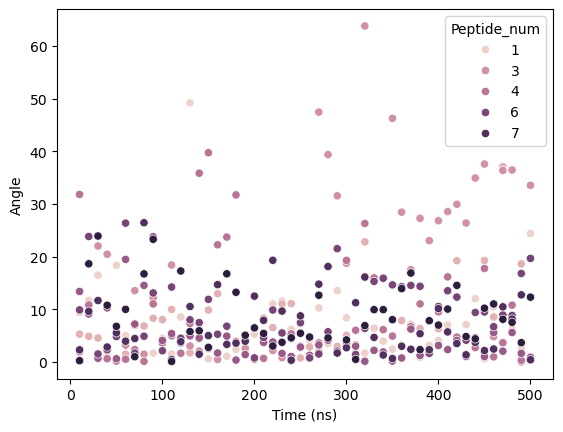

In [35]:
g = sns.scatterplot(
    data=df,
    x="Time (ns)",       
    y="Angle",       
    hue="Peptide_num")

### Plot the angles per time as lineplot

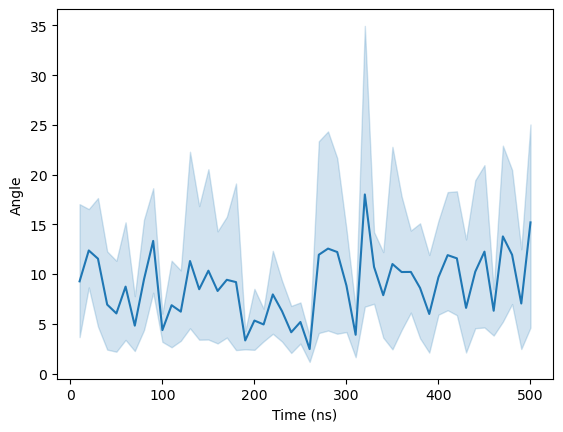

In [23]:

g = sns.lineplot(
    data=df,
    x="Time (ns)",       
    y="Angle")